In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import pymysql
import numpy as np
import pickle
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pygam import LinearGAM, s, f
import os
import warnings
warnings.filterwarnings(action='ignore') 

In [2]:
def pickleLoad(file):
    with open(file,"rb") as fr:
        dataframe = pickle.load(fr)
    return dataframe

In [3]:
%run -i './getTrainTestSet/getTrainTestSet_interpolation.py' 

In [4]:
# load train, test set data
X_train = pickleLoad('./dataset/dataset_interpolation/X_train.pkl')
X_test = pickleLoad('./dataset/dataset_interpolation/X_test.pkl')
y_train = pickleLoad('./dataset/dataset_interpolation/y_train.pkl')
y_test = pickleLoad('./dataset/dataset_interpolation/y_test.pkl')
ccsi = pickleLoad('./dataset/dataset_interpolation/ccsi.pkl')
predictors = pickleLoad('./dataset/dataset_interpolation/predictors.pkl')

* data preprocessing(standard scaling)

In [5]:
# 변수 스케일링
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test= scaler.transform(X_test)

### model 1. multiple linear regression

* 10-fold CV

In [6]:
model_lr = LinearRegression()
scores = cross_val_score(model_lr, X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error')
rmse_linearRegressionCV = np.sqrt(-scores)
rmse_lravg = rmse_linearRegressionCV.mean()
rmse_lrstd = rmse_linearRegressionCV.std()

In [7]:
print(" 10-fold cv RMSE: ", rmse_linearRegressionCV)
print("최종 CV RMSE = ", rmse_lravg)

 10-fold cv RMSE:  [4.32428142 4.28311908 5.52348655 6.25445314 4.80203246 5.15614792
 4.52345947 4.20939492 3.64826949 4.1686926 ]
최종 CV RMSE =  4.68933370624471


### model 2: Random Forest

In [8]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [9]:
# CV
rmse_randomforest, parameters_randomforest = [], []
numOfEstimators = np.power(2, [3,4,5,6])
maxFeatures = [1,2,3,4,5]
for i in maxFeatures:
    for j in numOfEstimators:
        # parameter search
        model_forest = RandomForestRegressor(max_features = i, n_estimators = j, warm_start = True, random_state = 23)
        parameters_randomforest.append(model_forest.get_params)
        # 10-fold CV
        scores = cross_val_score(model_forest, X_train, y_train, cv = k_fold, scoring = 'neg_mean_squared_error')
        rmse_randomforest.append(np.sqrt(-scores))
    

In [10]:
def getCVResult(rmse_list, model_num):
    cv_rmse =  rmse_list[model_num - 1].mean()
    std = rmse_list[model_num - 1].std()

    return cv_rmse, std

In [11]:
rmse_list, std_list = [], []
for i in range(1,21):
    cv_rmse, std = getCVResult(rmse_randomforest, i)
    rmse_list.append(cv_rmse)
    std_list.append(std)
    print(i, cv_rmse, std)
    

1 4.694818901310832 1.417701370741701
2 4.445480915961873 1.485375481314255
3 4.424978924903377 1.4239842287706537
4 4.388812047801826 1.279427728949003
5 4.378555771706108 1.3732986120401662
6 4.3449738959298445 1.4634513318588638
7 4.224800550336111 1.4338769049509794
8 4.109631861333856 1.3457048506566989
9 4.306176326852979 1.3242306000113204
10 3.998034458005158 1.334123520293274
11 4.02884765110052 1.3404801812717626
12 3.975217197250082 1.2602656678729152
13 4.176641844259976 1.2622380978772278
14 4.1504637872315415 1.2388499344839548
15 4.024729137558932 1.3309874050335682
16 3.9490395487707963 1.3263158818387752
17 4.22757078838046 1.2957665501341296
18 4.228820829513515 1.193391308981171
19 4.119991496429499 1.220731838777024
20 4.020438416964731 1.270892375228011


#### final random forest model selection

In [12]:
rmse_list.index(min(rmse_list))

15

model 후보 1~20번 중에, 14번모델이 가장 낮은 rmse 평균값을 갖고있음을 확인할 수 있다.

따라서, 14번 모델을 랜덤포레스트 대표모델로 활용하고자 한다.

In [13]:
# 대표 모델의 파라미터
parameters_randomforest[rmse_list.index(min(rmse_list))]

<bound method BaseEstimator.get_params of RandomForestRegressor(max_features=4, n_estimators=64, random_state=23,
                      warm_start=True)>

In [14]:
# 대표 모델의 평균 rmse와 std
rmse_forestavg = rmse_list[rmse_list.index(min(rmse_list))]
rmse_foreststd = std_list[rmse_list.index(min(rmse_list))]

In [15]:
# 대표 모델의 10-fold cv
rmse_randomforestCV = rmse_randomforest[rmse_list.index(min(rmse_list))]
rmse_randomforestCV

array([2.56583654, 3.77470984, 2.49497699, 3.16832468, 6.98308537,
       3.75226086, 2.65571229, 4.30855972, 5.10991292, 4.67701629])

In [16]:
print(" 10-fold cv RMSE: ", rmse_randomforestCV)
print("최종 CV RMSE = ", rmse_forestavg)

 10-fold cv RMSE:  [2.56583654 3.77470984 2.49497699 3.16832468 6.98308537 3.75226086
 2.65571229 4.30855972 5.10991292 4.67701629]
최종 CV RMSE =  3.9490395487707963


### model 3: GAM

In [17]:
X_train_df = pd.DataFrame(X_train, columns = ['keyword1', 'keyword2', 'keyword3', 'keyword4', 'keyword5', 'google', 'naver'])
y_train_df = np.array(y_train)
y_train_df = pd.DataFrame(y_train_df)

In [18]:
# CV
rmse_gam, parameters_gam = [], []
np.random.seed(1)
lams = np.random.rand(100, 7) # random points on [0, 1], with shape (100, 7)
lams = lams * 6 - 3 # shift values to -3, 3
lams = 10 ** lams # transforms values to 1e-3, 

K=10
for k in range(K):
    val_ind = list(range(20 * k, 20 * k + 20))
    if k == 9:
        val_ind = (range(20 * k, 20 * k + 21))
    X_train2 = X_train_df.drop(val_ind).to_numpy()
    y_train2 = y_train_df.drop(val_ind).to_numpy()
    X_val = X_train_df.loc[val_ind, :].to_numpy()
    y_val = y_train_df.loc[val_ind, :].to_numpy()
    # parameter search
    model_gam =  LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5)+ s(6)).gridsearch(X_train2, y_train2, lam=lams)
    parameters_gam.append(model_gam.get_params)
    y_hat = model_gam.predict(X_val)
    scores = mean_squared_error(y_val, y_hat)
    rmse_gam.append(np.sqrt(scores))
    
    

100% (100 of 100) |######################| Elapsed Time: 0:00:12 Time:  0:00:12
100% (100 of 100) |######################| Elapsed Time: 0:00:10 Time:  0:00:10
100% (100 of 100) |######################| Elapsed Time: 0:00:11 Time:  0:00:11
100% (100 of 100) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
100% (100 of 100) |######################| Elapsed Time: 0:00:14 Time:  0:00:14
100% (100 of 100) |######################| Elapsed Time: 0:00:15 Time:  0:00:15
100% (100 of 100) |######################| Elapsed Time: 0:00:15 Time:  0:00:15
100% (100 of 100) |######################| Elapsed Time: 0:00:13 Time:  0:00:13
100% (100 of 100) |######################| Elapsed Time: 0:00:13 Time:  0:00:13
100% (100 of 100) |######################| Elapsed Time: 0:00:15 Time:  0:00:15


In [19]:
rmse_gamavg = np.mean(rmse_gam)
rmse_gamstd = np.std(rmse_gam)
print(" 10-fold cv RMSE: ", rmse_gam)
print("최종 CV RMSE = ", rmse_gamavg)

 10-fold cv RMSE:  [4.2968711527001915, 4.491777600464691, 7.36356570817564, 6.1584929619829225, 4.818526262634055, 4.403505385162953, 5.139553550071442, 7.979048790445136, 3.6780481513151964, 8.784181921150223]
최종 CV RMSE =  5.7113571484102446


### model 4: Lasso Regression

In [20]:
# CV
rmse_lasso, parameters_lasso = [], []
alpha = [10, 1, 0.1, 0.01, 0.001]
for i in alpha:
    # parameter search
    model_lasso = Lasso(alpha = i, random_state = 23)
    parameters_lasso.append(model_lasso.get_params)
    # 10-fold CV
    scores = cross_val_score(model_lasso, X_train, y_train, cv = k_fold, scoring = 'neg_mean_squared_error')
    rmse_lasso.append(np.sqrt(-scores))
    

In [21]:
rmse_list, std_list = [], []
for i in range(1, 6):
    cv_rmse, std = getCVResult(rmse_lasso, i)
    rmse_list.append(cv_rmse)
    std_list.append(std)
    print(i, cv_rmse, std)
    

1 8.534342438712796 1.6582515921840515
2 4.884400095804817 1.0822911000842048
3 4.654171916764995 0.8892381880735692
4 4.633152470442409 0.7735599251187444
5 4.6342970702341955 0.7653746304432467


#### final lasso linear regression model selection

In [22]:
rmse_list.index(min(rmse_list))

3

model 후보 1~5번 중에, 3번모델이 가장 낮은 rmse 평균값을 갖고 있음을 확인할 수 있다.

따라서, 3번 모델을 라쏘 회귀 대표모델로 활용하고자 한다.

In [23]:
# 대표 모델의 파라미터
parameters_lasso[rmse_list.index(min(rmse_list))]

<bound method BaseEstimator.get_params of Lasso(alpha=0.01, random_state=23)>

In [24]:
# 대표 모델의 평균 rmse와 std
rmse_lassoavg = rmse_list[rmse_list.index(min(rmse_list))]
rmse_lassostd = std_list[rmse_list.index(min(rmse_list))]

In [25]:
# 대표 모델의 10-fold cv
rmse_lassoCV = rmse_lasso[rmse_list.index(min(rmse_list))]
rmse_lassoCV 

array([3.91724001, 5.40854455, 3.98810512, 4.25181788, 6.49509144,
       4.08978821, 4.21765937, 5.12344648, 4.56596369, 4.27386794])

###  Model간 CV RMSE 비교

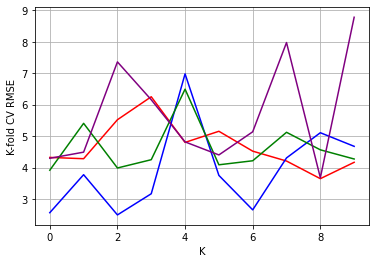

In [26]:
plt.plot(rmse_linearRegressionCV, color = 'red', label = 'Linear Regression')
plt.plot(rmse_randomforestCV, color = 'blue', label = 'Random Forest')
plt.plot(rmse_lassoCV, color = 'green', label = 'Lasso Linear Regression')
plt.plot(rmse_gam, color = 'purple', label = 'Lasso Linear Regression')
plt.xlabel("K")
plt.ylabel("K-fold CV RMSE")
plt.grid(True)

In [27]:
print(rmse_lravg, rmse_forestavg, rmse_lassoavg, rmse_gamavg)

4.68933370624471 3.9490395487707963 4.633152470442409 5.7113571484102446


## T-test

In [28]:
def tTest(rmse1, rmse2):
    mean = (rmse1 - rmse2).mean()
    sd = (rmse1 - rmse2).std()
    t_statistic = mean / (sd / np.sqrt(10)) ## 여기 n에 10?????
    return t_statistic

**H0**: linear regression model의 rmse = Random Forest model의 rmse<br>
즉, 두 모델의 성능에 차이가 없다.<br><br>
**H1**: 두 모델의 성능에 차이가 있다.

In [29]:
mean = np.average(rmse_linearRegressionCV - rmse_randomforestCV)
sd = (rmse_linearRegressionCV - rmse_randomforestCV).std()
print('평균: ', mean)
tTest(rmse_linearRegressionCV, rmse_randomforestCV)

평균:  0.7402941574739133


1.3702735552161485

t_0.05,9 = 1.844 <br>
t_0.025,9 = 2.262 <br><br>

유의수준 0.025에서 귀무가설이 기각되지 않는다. 따라서, linear regression model과 Random forest model의 성능에는 차이가 없다.


**H0**: linear regression model의 rmse = Lasso linear regression model의 rmse<br>
즉, 두 모델의 성능에 차이가 없다.<br><br>
**H1**: 두 모델의 성능에 차이가 있다.

In [30]:
mean = np.average(rmse_linearRegressionCV - rmse_lassoCV)
sd = (rmse_linearRegressionCV - rmse_lassoCV).std()
print('평균: ', mean)
tTest(rmse_linearRegressionCV, rmse_lassoCV) 

평균:  0.05618123580230119


0.15259854699155181

t_0.05,9 = 1.844 <br>
t_0.025,9 = 2.262 <br><br>

유의수준 0.025에서 귀무가설이 기각되지않는다. 따라서, linear regression model과 Lasso linear regression model의 성능에는 차이가 없다.

**H0**: Random Forest model의 rmse = Lasso linear regression model의 rmse<br>
즉, 두 모델의 성능에 차이가 없다.<br><br>
**H1**: 두 모델의 성능에 차이가 있다.

In [31]:
mean = np.average(rmse_randomforestCV - rmse_lassoCV)
sd = (rmse_randomforestCV - rmse_lassoCV).std()
print('평균: ', mean)
tTest(rmse_randomforestCV, rmse_lassoCV)

평균:  -0.6841129216716122


-2.5614513948331608

t_0.05,9 = 1.844 <br>
t_0.025,9 = 2.262 <br><br>

유의수준 0.05에서 귀무가설이 기각된다. 따라서, random forest model과 Lasso linear regression model의 성능에는 차이가 있다. t통계량이 음수값이 나왔으므로 random forest model의 rmse가 더 작아고 판단된다. 따라서 random forest model의 성능이 더 좋다고 할 수 있다.

**H0**: linear regression model의 rmse = Generalized additive model의 rmse<br>
즉, 두 모델의 성능에 차이가 없다.<br><br>

**H1**: 두 모델의 성능에 차이가 있다.

In [32]:
mean = np.average(rmse_linearRegressionCV - rmse_gam)
sd = (rmse_linearRegressionCV - rmse_gam).std()
print('평균: ', mean)
tTest(rmse_linearRegressionCV, rmse_gam)

평균:  -1.022023442165535


-1.8831567772200986

t_0.05,9 = 1.844 <br>
t_0.025,9 = 2.262 <br><br>

유의수준 0.05에서 귀무가설이 기각되지않는다. 따라서, linear regression model과 Generalized additive model의 성능에는 차이가 없다.

**H0**:  Random Forest model의 rmse = Generalized additive model의 rmse<br>
즉, 두 모델의 성능에 차이가 없다.<br><br>
**H1**: 두 모델의 성능에 차이가 있다.

In [33]:
mean = np.average(rmse_randomforestCV - rmse_gam)
sd = (rmse_randomforestCV - rmse_gam).std()
print('평균: ', mean)
tTest(rmse_randomforestCV, rmse_gam)

평균:  -1.7623175996394487


-2.523584687834601

t_0.05,9 = 1.844 <br>
t_0.025,9 = 2.262 <br><br>

유의수준 0.05에서 귀무가설이 기각되지않는다. 따라서,  Random Forest model과 Generalized additive model의 성능에는 차이가 없다.

**H0**: Lasso linear regression model의 rmse = Generalized additive model의 rmse<br>
즉, 두 모델의 성능에 차이가 없다.<br><br>
**H1**: 두 모델의 성능에 차이가 있다.

In [34]:
mean = np.average(rmse_lassoCV - rmse_gam)
sd = (rmse_lassoCV - rmse_gam).std()
print('평균: ', mean)
tTest(rmse_lassoCV, rmse_gam)

평균:  -1.0782046779678363


-1.7622654874049497

t_0.05,9 = 1.844 <br>
t_0.025,9 = 2.262 <br><br>

유의수준 0.05에서 귀무가설이 기각되지않는다. 따라서, Lasso linear regression model과 Generalized additive model의 성능에는 차이가 없다.

결론적으로, random forest model의 성능이 좋다고 할 수 있다.

## Testing

In [35]:
parameters_randomforest[rmse_list.index(min(rmse_list))]

<bound method BaseEstimator.get_params of RandomForestRegressor(max_features=1, n_estimators=64, random_state=23,
                      warm_start=True)>

In [36]:
model_forest = RandomForestRegressor(n_estimators=32, max_features=4, random_state=23, warm_start=True)
model_forest.fit(X_train, y_train)
y_pred = model_forest.predict(X_test) # y_pred: test set을 넣어서 얻은 예측 값

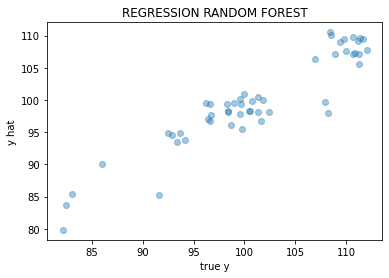

In [37]:
# test set에 대한 실제값과 예측 값의 추세 확인
plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel("true y")
plt.ylabel("y hat")
plt.title("REGRESSION RANDOM FOREST")
plt.show()

* model evaluating

In [38]:
print("R square: ", model_forest.score(X_train, y_train))
print("training RMSE: ", np.sqrt(mean_squared_error(y_train, model_forest.predict(X_train))))
print("test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))

R square:  0.9710615961186133
training RMSE:  1.4743529382826035
test RMSE:  3.0992034799127786


## Step5. Visulization
### weekly record 예측하기(weekly CCSI)

In [39]:
X = scaler.transform(predictors.loc[:, ['keyword1', 'keyword2', 'keyword3', 'keyword4', 'keyword5', 'google', 'naver']])

In [40]:
# weekly 레코드들을 예측모델에 집어넣어, 각 레코드에 대한 예측값 얻음
pred_ccsi = model_forest.predict(X)

In [41]:
# tmp = pd.merge(predictors, ccsi).drop(['id'], axis=1)
tmp = pd.merge(predictors, ccsi)
tmp['pred'] = pred_ccsi
tmp.head()

,year,month,day,keyword1,keyword2,keyword3,keyword4,keyword5,google,naver,ccsi,pred
0,2016,1,4,825,419,437,986,168,53.0,26.05846,93.575,94.902812
1,2016,1,11,770,348,351,626,182,58.0,25.16599,95.550,95.859375
2,2016,1,18,918,422,441,445,147,74.0,27.38639,97.525,97.702031
3,2016,1,25,1067,425,567,383,148,59.0,24.72622,99.500,98.782031
4,2016,2,1,899,341,485,289,110,63.0,23.01888,99.040,98.728125


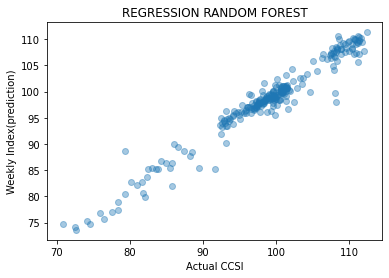

In [42]:
# true와 pred의 추세 확인
plt.scatter(tmp['ccsi'], tmp['pred'], alpha=0.4)
plt.xlabel("Actual CCSI")
plt.ylabel("Weekly Index(prediction)")
plt.title("REGRESSION RANDOM FOREST")
plt.show()

In [43]:
# weekly별 단기지표 값에 대한 MSE
print("RMSE about weekly CCSI: ", np.sqrt(mean_squared_error(tmp['ccsi'], tmp['pred'])))

RMSE about weekly CCSI:  1.9177276634950446


### visaulization
* 시계열 그래프

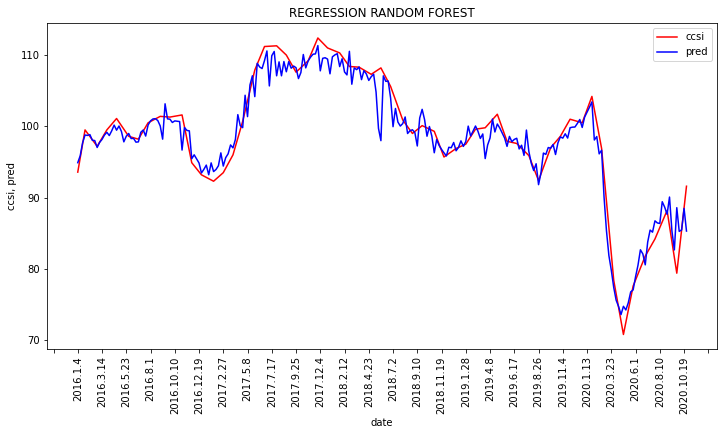

In [44]:
# 시계열 그래프를 그리기위해, 날짜 column 생성
tmp['date'] = tmp[['year', 'month', 'day']].apply(lambda x: '.'.join(map(str, x)), axis=1)

plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(tmp['date'], tmp['ccsi'], color = 'red', label = 'ccsi')
plt.plot(tmp['date'], tmp['pred'], color = 'blue', label = 'pred')
plt.xlabel("date")
plt.ylabel("ccsi, pred")
ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(90)
plt.title("REGRESSION RANDOM FOREST")
plt.legend()
plt.show()

* moving avg 시계열 그래프

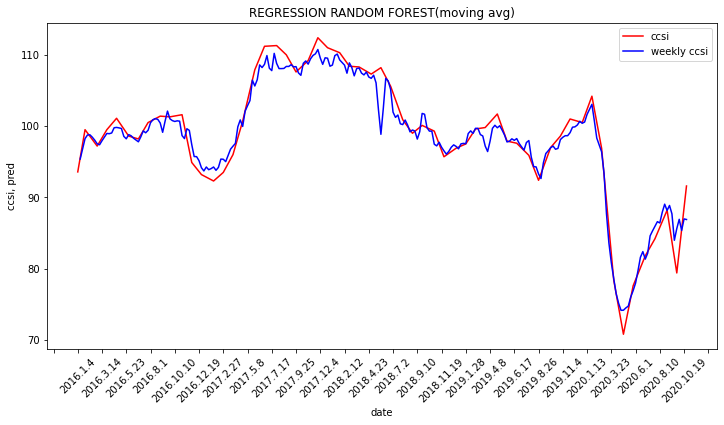

In [45]:
rolling = pd.Series.rolling(tmp['pred'], window = 2, center = False).mean()

plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(tmp['date'], tmp['ccsi'], color = 'red', label = 'ccsi')
rolling.plot(color = 'blue', label = 'weekly ccsi')
plt.xlabel("date")
plt.ylabel("ccsi, pred")
ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(45)
plt.title("REGRESSION RANDOM FOREST(moving avg)")
plt.legend()
plt.show()

2주 간의 단기 지표들을 평균낸 값을 weekly CCSI로 활용하고자함. <br>
시각화 결과, 주간 레코드에 대한 예측 결과를 바로 활용하는 것 보다 2주 간의 예측 결과 평균을 활용하는 것이 덜 들쑥날쑥하다.

## Step6. Develop weekly CCSI(주간 경기선행지수)

In [46]:
weekly_CLI = []
for i in range(len(tmp)):
    if i == 0 :
        cli = tmp.pred.iloc[i]
        weekly_CLI.append(cli)
        continue
    
    cli = (tmp.pred.iloc[i-1] + tmp.pred.iloc[i]) / 2
    weekly_CLI.append(cli)
    
tmp['weeklyCLI'] = weekly_CLI
tmp[['date', 'weeklyCLI']]

,date,weeklyCLI
0,2016.1.4,94.902812
1,2016.1.11,95.381094
2,2016.1.18,96.780703
3,2016.1.25,98.242031
4,2016.2.1,98.755078
...,...,...
247,2020.9.28,85.625625
248,2020.10.5,86.923750
249,2020.10.12,85.365234
250,2020.10.19,86.979922
